# BPI Challenge 2019 - Compliance Analysis

This notebook performs comprehensive compliance analysis on the preprocessed BPI Challenge 2019 event logs to answer:

**Business Question 1 (BQ1)**: In which category of items does non-compliance most severely disrupt the expected process flow?

## Analysis Framework
- **Compliance Rules**: Category-specific process requirements
- **Impact Scoring**: Occurrence impact × Throughput impact  
- **Process Discovery**: Compliant process models per category
- **Deviation Detection**: Model alignment and compliance checking
- **Statistical Analysis**: Case duration and performance metrics

In [12]:
# Import Required Libraries
import os
import gc
import json
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Process Mining Libraries
import pm4py
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.algo.conformance.alignments.petri_net import algorithm as alignments
from pm4py.algo.conformance.tokenreplay import algorithm as token_replay
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.visualization.dfg import visualizer as dfg_visualizer
from pm4py.statistics.traces.generic.log import case_statistics

# Configure visualization
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

print("Libraries imported successfully")

Libraries imported successfully


## 1. Data Preprocessing and Configuration

### Item Categories and Compliance Rules
Define the four main item categories and their specific compliance requirements based on the BPI Challenge 2019 domain knowledge.

In [13]:
# Configuration for compliance analysis
DATA_DIR = './data/filtered'
INCOMPLETE_DIR = os.path.join(DATA_DIR, 'incomplete')

# Item categories and their expected process patterns
ITEM_CATEGORIES = {
    'group_3_way_after': {
        'name': '3-way match, invoice after GR',
        'file': 'group_3_way_after.xes',
        'incomplete_file': 'group_3_way_after_incomplete.xes',
        'compliance_rules': [
            'Goods receipt must be recorded',
            'Invoice receipt must be recorded', 
            'Goods receipt before invoice',
            'Values must match (item, goods receipt, invoice)'
        ],
        'expected_activities': ['Create Purchase Order Item', 'Record Goods Receipt', 'Record Invoice Receipt', 'Clear Invoice'],
        'required_sequence': [('Record Goods Receipt', 'Record Invoice Receipt')]
    },
    'group_3_way_before': {
        'name': '3-way match, invoice before GR',
        'file': 'group_3_way_before.xes',
        'incomplete_file': 'group_3_way_before_incomplete.xes',
        'compliance_rules': [
            'Goods receipt must be recorded',
            'Invoice receipt must be recorded',
            'Invoice may precede goods receipt',
            'Values must match (creation, invoice, goods-receipt)'
        ],
        'expected_activities': ['Create Purchase Order Item', 'Record Invoice Receipt', 'Record Goods Receipt', 'Clear Invoice'],
        'required_sequence': []  # No strict sequence requirement
    },
    'group_2_way': {
        'name': '2-way match',
        'file': 'group_2_way.xes',
        'incomplete_file': 'group_2_way_incomplete.xes',
        'compliance_rules': [
            'Only invoice receipt required',
            'No goods receipt',
            'Invoice value must match original item value'
        ],
        'expected_activities': ['Create Purchase Order Item', 'Record Invoice Receipt', 'Clear Invoice'],
        'forbidden_activities': ['Record Goods Receipt']
    },
    'group_consignment': {
        'name': 'Consignment',
        'file': 'group_consignment.xes',
        'incomplete_file': 'group_consignment_incomplete.xes',
        'compliance_rules': [
            'Goods receipt expected',
            'No invoice at purchase-order level',
            'Separate consignment invoicing process'
        ],
        'expected_activities': ['Create Purchase Order Item', 'Record Goods Receipt'],
        'forbidden_activities': ['Record Invoice Receipt', 'Clear Invoice']
    }
}

# Case attributes
CASE_ID_ATTRIBUTE = "concept:name"
CATEGORY_ATTRIBUTE = "Item Category"
TIMESTAMP_ATTRIBUTE = "time:timestamp"
ACTIVITY_ATTRIBUTE = "concept:name"
RESOURCE_ATTRIBUTE = "org:resource"

print("Configuration loaded successfully")
print(f"Analyzing {len(ITEM_CATEGORIES)} item categories")

Configuration loaded successfully
Analyzing 4 item categories


## 2. Data Loading and Initial Analysis

Load preprocessed event logs for both compliant and non-compliant cases across all item categories.

In [14]:
def load_category_logs(category_key, category_info):
    """Load both compliant and incomplete logs for a category"""
    logs = {'compliant': None, 'incomplete': None, 'stats': {}}
    
    # Load compliant cases
    compliant_path = os.path.join(DATA_DIR, category_info['file'])
    if os.path.exists(compliant_path):
        logs['compliant'] = xes_importer.apply(compliant_path)
        logs['stats']['compliant_cases'] = len(logs['compliant'])
        logs['stats']['compliant_events'] = sum(len(trace) for trace in logs['compliant'])
        logger.info(f"{category_key}: Loaded {logs['stats']['compliant_cases']} compliant cases")
    
    # Load incomplete cases
    incomplete_path = os.path.join(INCOMPLETE_DIR, category_info['incomplete_file'])
    if os.path.exists(incomplete_path):
        logs['incomplete'] = xes_importer.apply(incomplete_path)
        logs['stats']['incomplete_cases'] = len(logs['incomplete'])
        logs['stats']['incomplete_events'] = sum(len(trace) for trace in logs['incomplete'])
        logger.info(f"{category_key}: Loaded {logs['stats']['incomplete_cases']} incomplete cases")
    else:
        logs['stats']['incomplete_cases'] = 0
        logs['stats']['incomplete_events'] = 0
    
    # Calculate totals and compliance rate
    logs['stats']['total_cases'] = logs['stats']['compliant_cases'] + logs['stats']['incomplete_cases']
    logs['stats']['compliance_rate'] = (
        logs['stats']['compliant_cases'] / logs['stats']['total_cases'] 
        if logs['stats']['total_cases'] > 0 else 0
    )
    
    return logs

# Load all category logs
category_logs = {}
overall_stats = []

print("Loading preprocessed event logs...")
for category_key, category_info in ITEM_CATEGORIES.items():
    print(f"\n--- Loading {category_info['name']} ---")
    category_logs[category_key] = load_category_logs(category_key, category_info)
    
    stats = category_logs[category_key]['stats']
    stats['category'] = category_info['name']
    stats['category_key'] = category_key
    overall_stats.append(stats)

# Create summary DataFrame
summary_df = pd.DataFrame(overall_stats)
print("\n=== OVERALL SUMMARY ===")
print(summary_df[['category', 'total_cases', 'compliant_cases', 'incomplete_cases', 'compliance_rate']])

Loading preprocessed event logs...

--- Loading 3-way match, invoice after GR ---


parsing log, completed traces ::   0%|          | 0/7931 [00:00<?, ?it/s]

INFO:__main__:group_3_way_after: Loaded 7931 compliant cases


parsing log, completed traces ::   0%|          | 0/5104 [00:00<?, ?it/s]

INFO:__main__:group_3_way_after: Loaded 5104 incomplete cases



--- Loading 3-way match, invoice before GR ---


parsing log, completed traces ::   0%|          | 0/147240 [00:00<?, ?it/s]

INFO:__main__:group_3_way_before: Loaded 147240 compliant cases


parsing log, completed traces ::   0%|          | 0/27605 [00:00<?, ?it/s]

INFO:__main__:group_3_way_before: Loaded 27605 incomplete cases



--- Loading 2-way match ---


parsing log, completed traces ::   0%|          | 0/17 [00:00<?, ?it/s]

INFO:__main__:group_2_way: Loaded 17 compliant cases


parsing log, completed traces ::   0%|          | 0/272 [00:00<?, ?it/s]

INFO:__main__:group_2_way: Loaded 272 incomplete cases



--- Loading Consignment ---


parsing log, completed traces ::   0%|          | 0/10828 [00:00<?, ?it/s]

INFO:__main__:group_consignment: Loaded 10828 compliant cases


parsing log, completed traces ::   0%|          | 0/870 [00:00<?, ?it/s]

INFO:__main__:group_consignment: Loaded 870 incomplete cases



=== OVERALL SUMMARY ===
                         category  total_cases  compliant_cases  \
0   3-way match, invoice after GR        13035             7931   
1  3-way match, invoice before GR       174845           147240   
2                     2-way match          289               17   
3                     Consignment        11698            10828   

   incomplete_cases  compliance_rate  
0              5104         0.608439  
1             27605         0.842117  
2               272         0.058824  
3               870         0.925628  


## 3. Process Model Discovery

Discover compliant process models for each item category using the Inductive Miner algorithm. These models represent the expected, compliant process flows.

In [ ]:
def discover_process_model(log, category_name):
    """Discover process model using Inductive Miner"""
    if log is None or len(log) == 0:
        return None, None, None
    
    try:
        # Apply Inductive Miner to discover process model
        process_tree = inductive_miner.apply(log)
        net, initial_marking, final_marking = pm4py.convert_to_petri_net(process_tree)
        
        logger.info(f"Discovered process model for {category_name}: {len(net.places)} places, {len(net.transitions)} transitions")
        return net, initial_marking, final_marking
    
    except Exception as e:
        logger.error(f"Error discovering model for {category_name}: {str(e)}")
        return None, None, None

# Discover process models for compliant cases
process_models = {}
print("Discovering compliant process models...")

for category_key, logs in category_logs.items():
    category_name = ITEM_CATEGORIES[category_key]['name']
    print(f"\n--- Discovering model for {category_name} ---")
    
    if logs['compliant'] is not None:
        net, im, fm = discover_process_model(logs['compliant'], category_name)
        process_models[category_key] = {
            'net': net,
            'initial_marking': im,
            'final_marking': fm,
            'log': logs['compliant']
        }
        
        # Basic model statistics
        if net is not None:
            print(f"Model discovered: {len(net.places)} places, {len(net.transitions)} transitions")
                 # Get activity frequencies
        from pm4py.statistics.attributes.log import get as attributes_get
        activities = attributes_get.get_attribute_values(logs['compliant'], ACTIVITY_ATTRIBUTE)
        print(f"Activities in compliant cases: {list(activities.keys())}")
    else:
        print(f"No compliant cases found for {category_name}")
        process_models[category_key] = None

print(f"\nDiscovered process models for {len([k for k, v in process_models.items() if v is not None])} categories")

# Execute this cell
print("Process model discovery completed successfully")

Discovering compliant process models...

--- Discovering model for 3-way match, invoice after GR ---


## 4. Case Duration Analysis

Calculate case durations for both compliant and non-compliant cases to understand throughput impact.

In [16]:
def calculate_case_durations(log, category_name):
    """Calculate case durations and throughput metrics"""
    if log is None or len(log) == 0:
        return pd.DataFrame()
    
    durations = []
    
    for trace in log:
        if len(trace) < 2:
            continue
            
        # Get first and last event timestamps
        start_time = trace[0][TIMESTAMP_ATTRIBUTE]
        end_time = trace[-1][TIMESTAMP_ATTRIBUTE]
        
        # Calculate duration in hours
        duration_hours = (end_time - start_time).total_seconds() / 3600
        
        durations.append({
            'case_id': trace.attributes[CASE_ID_ATTRIBUTE],
            'category': category_name,
            'duration_hours': duration_hours,
            'duration_days': duration_hours / 24,
            'num_events': len(trace),
            'start_time': start_time,
            'end_time': end_time
        })
    
    return pd.DataFrame(durations)

# Calculate durations for all categories and compliance types
duration_data = []

print("Calculating case durations...")
for category_key, logs in category_logs.items():
    category_name = ITEM_CATEGORIES[category_key]['name']
    print(f"\n--- Analyzing durations for {category_name} ---")
    
    # Compliant cases
    if logs['compliant'] is not None:
        compliant_durations = calculate_case_durations(logs['compliant'], category_name)
        compliant_durations['compliance_status'] = 'Compliant'
        duration_data.append(compliant_durations)
        
        print(f"Compliant cases - Mean: {compliant_durations['duration_days'].mean():.2f} days, "
              f"Median: {compliant_durations['duration_days'].median():.2f} days")
    
    # Incomplete cases
    if logs['incomplete'] is not None:
        incomplete_durations = calculate_case_durations(logs['incomplete'], category_name)
        incomplete_durations['compliance_status'] = 'Non-compliant'
        duration_data.append(incomplete_durations)
        
        print(f"Non-compliant cases - Mean: {incomplete_durations['duration_days'].mean():.2f} days, "
              f"Median: {incomplete_durations['duration_days'].median():.2f} days")

# Combine all duration data
all_durations_df = pd.concat(duration_data, ignore_index=True) if duration_data else pd.DataFrame()

if not all_durations_df.empty:
    print(f"\nTotal cases analyzed: {len(all_durations_df)}")
    print("\nDuration summary by category and compliance:")
    summary_stats = all_durations_df.groupby(['category', 'compliance_status'])['duration_days'].agg([
        'count', 'mean', 'median', 'std', 
        lambda x: np.percentile(x, 95)
    ]).round(2)
    summary_stats.columns = ['Count', 'Mean_Days', 'Median_Days', 'Std_Days', '95th_Percentile_Days']
    print(summary_stats)

Calculating case durations...

--- Analyzing durations for 3-way match, invoice after GR ---
Compliant cases - Mean: 87.05 days, Median: 82.18 days
Non-compliant cases - Mean: 41.56 days, Median: 0.04 days

--- Analyzing durations for 3-way match, invoice before GR ---
Compliant cases - Mean: 87.05 days, Median: 82.18 days
Non-compliant cases - Mean: 41.56 days, Median: 0.04 days

--- Analyzing durations for 3-way match, invoice before GR ---
Compliant cases - Mean: 84.25 days, Median: 79.73 days
Non-compliant cases - Mean: 51.11 days, Median: 23.27 days

--- Analyzing durations for 2-way match ---
Compliant cases - Mean: 134.87 days, Median: 126.01 days
Non-compliant cases - Mean: 11.32 days, Median: 0.03 days

--- Analyzing durations for Consignment ---
Compliant cases - Mean: 84.25 days, Median: 79.73 days
Non-compliant cases - Mean: 51.11 days, Median: 23.27 days

--- Analyzing durations for 2-way match ---
Compliant cases - Mean: 134.87 days, Median: 126.01 days
Non-compliant case

## 5. Compliance Checking and Deviation Detection

Use process model alignment to detect deviations and measure compliance for each category.

In [17]:
def perform_compliance_checking(log, net, initial_marking, final_marking, category_name):
    """Perform compliance checking using alignments"""
    if log is None or net is None or len(log) == 0:
        return None
    
    try:
        print(f"Performing compliance checking for {category_name}...")
        
        # Use token-based replay for efficiency (faster than alignments)
        replay_result = token_replay.apply(log, net, initial_marking, final_marking)
        
        # Extract compliance metrics
        compliant_traces = 0
        total_cost = 0
        deviations = []
        
        for trace_idx, trace_result in enumerate(replay_result):
            trace = log[trace_idx]
            case_id = trace.attributes[CASE_ID_ATTRIBUTE]
            
            # Check if trace is compliant (no missing or remaining tokens)
            is_compliant = (trace_result['missing_tokens'] == 0 and 
                          trace_result['remaining_tokens'] == 0 and
                          trace_result['trace_is_fit'])
            
            if is_compliant:
                compliant_traces += 1
            else:
                deviations.append({
                    'case_id': case_id,
                    'missing_tokens': trace_result['missing_tokens'],
                    'remaining_tokens': trace_result['remaining_tokens'],
                    'trace_is_fit': trace_result['trace_is_fit']
                })
        
        compliance_rate = compliant_traces / len(log) if len(log) > 0 else 0
        
        # Calculate average fitness safely
        fitness_values = []
        for tr in replay_result:
            if 'trace_fitness' in tr:
                fitness_values.append(tr['trace_fitness'])
            elif 'trace_is_fit' in tr:
                fitness_values.append(1.0 if tr['trace_is_fit'] else 0.0)
            else:
                fitness_values.append(0.0)
        
        avg_fitness = sum(fitness_values) / len(fitness_values) if fitness_values else 0.0
        
        result = {
            'category': category_name,
            'total_cases': len(log),
            'compliant_cases': compliant_traces,
            'compliance_rate': compliance_rate,
            'deviations': deviations,
            'avg_fitness': avg_fitness
        }
        
        print(f"Compliance rate: {compliance_rate:.2%}, Average fitness: {result['avg_fitness']:.3f}")
        return result
        
    except Exception as e:
        logger.error(f"Error in compliance checking for {category_name}: {str(e)}")
        return None

# Perform compliance checking for all categories
compliance_results = {}

print("Performing compliance checking against discovered models...")
for category_key, model_info in process_models.items():
    if model_info is not None:
        category_name = ITEM_CATEGORIES[category_key]['name']
        
        # Check compliance of the compliant log against its own model
        compliant_result = perform_compliance_checking(
            model_info['log'], 
            model_info['net'], 
            model_info['initial_marking'], 
            model_info['final_marking'],
            f"{category_name} (Compliant)"
        )
        
        # Check compliance of incomplete cases against the compliant model
        incomplete_log = category_logs[category_key]['incomplete']
        incomplete_result = perform_compliance_checking(
            incomplete_log,
            model_info['net'], 
            model_info['initial_marking'], 
            model_info['final_marking'],
            f"{category_name} (Non-compliant)"
        )
        
        compliance_results[category_key] = {
            'compliant': compliant_result,
            'incomplete': incomplete_result
        }

print("\nCompliance checking completed")

Performing compliance checking against discovered models...
Performing compliance checking for 3-way match, invoice after GR (Compliant)...


replaying log with TBR, completed traces ::   0%|          | 0/1388 [00:00<?, ?it/s]

Compliance rate: 100.00%, Average fitness: 1.000
Performing compliance checking for 3-way match, invoice after GR (Non-compliant)...


replaying log with TBR, completed traces ::   0%|          | 0/2209 [00:00<?, ?it/s]

Compliance rate: 5.37%, Average fitness: 0.957
Performing compliance checking for 3-way match, invoice before GR (Compliant)...


replaying log with TBR, completed traces ::   0%|          | 0/4444 [00:00<?, ?it/s]

Compliance rate: 100.00%, Average fitness: 1.000
Performing compliance checking for 3-way match, invoice before GR (Non-compliant)...


replaying log with TBR, completed traces ::   0%|          | 0/1343 [00:00<?, ?it/s]

Compliance rate: 90.87%, Average fitness: 0.963
Performing compliance checking for 2-way match (Compliant)...


replaying log with TBR, completed traces ::   0%|          | 0/5 [00:00<?, ?it/s]

Compliance rate: 100.00%, Average fitness: 1.000
Performing compliance checking for 2-way match (Non-compliant)...


replaying log with TBR, completed traces ::   0%|          | 0/15 [00:00<?, ?it/s]

Compliance rate: 0.00%, Average fitness: 0.566
Performing compliance checking for Consignment (Compliant)...


replaying log with TBR, completed traces ::   0%|          | 0/110 [00:00<?, ?it/s]

Compliance rate: 100.00%, Average fitness: 1.000
Performing compliance checking for Consignment (Non-compliant)...


replaying log with TBR, completed traces ::   0%|          | 0/86 [00:00<?, ?it/s]

Compliance rate: 27.13%, Average fitness: 0.826

Compliance checking completed


## 6. Impact Scoring and Risk Assessment

Calculate impact scores using the risk matrix approach: Impact = Occurrence Impact × Throughput Impact

In [18]:
def calculate_impact_scores(category_logs, all_durations_df, compliance_results):
    """Calculate comprehensive impact scores for each category"""
    impact_scores = []
    
    for category_key, logs in category_logs.items():
        category_name = ITEM_CATEGORIES[category_key]['name']
        stats = logs['stats']
        
        if stats['total_cases'] == 0:
            continue
        
        # Occurrence Impact: proportion of non-compliant cases
        occurrence_impact = stats['incomplete_cases'] / stats['total_cases']
        
        # Throughput Impact: analyze duration differences
        category_durations = all_durations_df[all_durations_df['category'] == category_name]
        
        if len(category_durations) > 0:
            # Calculate throughput metrics
            compliant_durations = category_durations[
                category_durations['compliance_status'] == 'Compliant'
            ]['duration_days']
            
            noncompliant_durations = category_durations[
                category_durations['compliance_status'] == 'Non-compliant'
            ]['duration_days']
            
            # Base throughput impact on mean duration and 95th percentile
            mean_duration = category_durations['duration_days'].mean()
            p95_duration = np.percentile(category_durations['duration_days'], 95)
            
            # Normalize throughput impact (using log scale for large durations)
            throughput_impact = np.log1p(mean_duration) / 10  # Scaled for readability
            throughput_impact_p95 = np.log1p(p95_duration) / 10
            
            # Duration difference impact (if both compliant and non-compliant exist)
            duration_difference_impact = 0
            if len(compliant_durations) > 0 and len(noncompliant_durations) > 0:
                duration_difference = noncompliant_durations.mean() - compliant_durations.mean()
                duration_difference_impact = max(0, duration_difference / compliant_durations.mean())
        else:
            mean_duration = 0
            p95_duration = 0
            throughput_impact = 0
            throughput_impact_p95 = 0
            duration_difference_impact = 0
        
        # Combined impact scores
        impact_score_mean = occurrence_impact * throughput_impact
        impact_score_p95 = occurrence_impact * throughput_impact_p95
        
        # Get compliance checking results
        compliance_info = compliance_results.get(category_key, {})
        fitness_score = 0
        if compliance_info.get('compliant'):
            fitness_score = compliance_info['compliant'].get('avg_fitness', 0)
        
        impact_data = {
            'category': category_name,
            'category_key': category_key,
            'total_cases': stats['total_cases'],
            'compliant_cases': stats['compliant_cases'],
            'noncompliant_cases': stats['incomplete_cases'],
            'occurrence_impact': occurrence_impact,
            'mean_duration_days': mean_duration,
            'p95_duration_days': p95_duration,
            'throughput_impact_mean': throughput_impact,
            'throughput_impact_p95': throughput_impact_p95,
            'duration_difference_impact': duration_difference_impact,
            'impact_score_mean': impact_score_mean,
            'impact_score_p95': impact_score_p95,
            'process_fitness': fitness_score,
            'compliance_rate': stats['compliance_rate']
        }
        
        impact_scores.append(impact_data)
    
    return pd.DataFrame(impact_scores)

# Calculate impact scores
impact_df = calculate_impact_scores(category_logs, all_durations_df, compliance_results)

print("Impact Scoring Results:")
print("=" * 60)

# Sort by impact score (mean-based)
impact_df_sorted = impact_df.sort_values('impact_score_mean', ascending=False)

for _, row in impact_df_sorted.iterrows():
    print(f"\n{row['category']}:")
    print(f"  Total Cases: {row['total_cases']:,}")
    print(f"  Non-compliance Rate: {row['occurrence_impact']:.1%}")
    print(f"  Mean Duration: {row['mean_duration_days']:.1f} days")
    print(f"  95th Percentile Duration: {row['p95_duration_days']:.1f} days")
    print(f"  Impact Score (Mean): {row['impact_score_mean']:.4f}")
    print(f"  Impact Score (P95): {row['impact_score_p95']:.4f}")
    print(f"  Process Fitness: {row['process_fitness']:.3f}")

# Summary table
print(f"\n{'='*60}")
print("IMPACT RANKING (by Mean-based Impact Score):")
print(f"{'='*60}")
ranking_df = impact_df_sorted[['category', 'occurrence_impact', 'impact_score_mean', 'impact_score_p95']].copy()
ranking_df.columns = ['Category', 'Non-compliance Rate', 'Impact Score (Mean)', 'Impact Score (P95)']
print(ranking_df.to_string(index=False, float_format='%.4f'))

Impact Scoring Results:

2-way match:
  Total Cases: 289
  Non-compliance Rate: 94.1%
  Mean Duration: 18.6 days
  95th Percentile Duration: 143.9 days
  Impact Score (Mean): 0.2800
  Impact Score (P95): 0.4683
  Process Fitness: 1.000

3-way match, invoice after GR:
  Total Cases: 13,035
  Non-compliance Rate: 39.2%
  Mean Duration: 69.6 days
  95th Percentile Duration: 184.4 days
  Impact Score (Mean): 0.1667
  Impact Score (P95): 0.2045
  Process Fitness: 1.000

3-way match, invoice before GR:
  Total Cases: 174,845
  Non-compliance Rate: 15.8%
  Mean Duration: 79.4 days
  95th Percentile Duration: 154.0 days
  Impact Score (Mean): 0.0693
  Impact Score (P95): 0.0796
  Process Fitness: 1.000

Consignment:
  Total Cases: 11,698
  Non-compliance Rate: 7.4%
  Mean Duration: 25.0 days
  95th Percentile Duration: 63.7 days
  Impact Score (Mean): 0.0242
  Impact Score (P95): 0.0310
  Process Fitness: 1.000

IMPACT RANKING (by Mean-based Impact Score):
                      Category  Non-c

## 7. Statistical Analysis and Visualization

Perform statistical analysis to validate findings and create visualizations to support the conclusions.

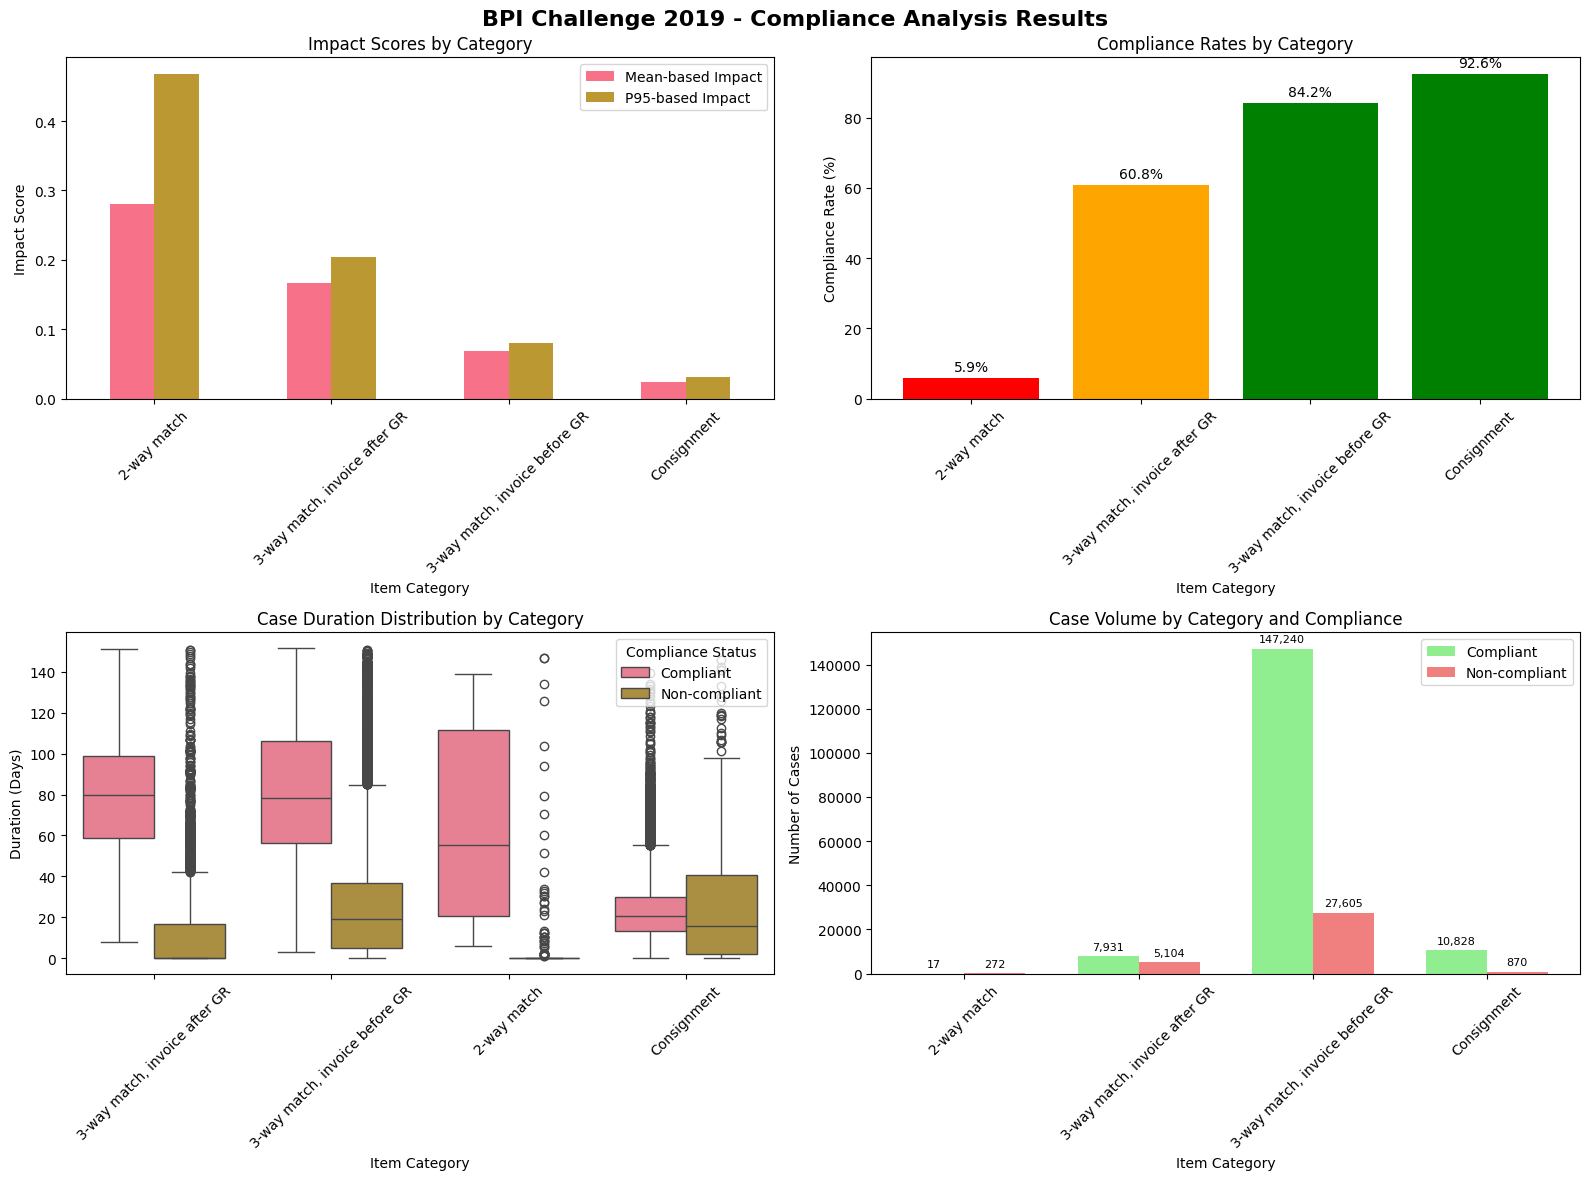


STATISTICAL ANALYSIS

3-way match, invoice after GR:
  Compliant cases duration: 87.05 ± 46.19 days
  Non-compliant cases duration: 41.56 ± 80.87 days
  Mann-Whitney U test p-value: 0.0000
  Statistical significance: Yes

3-way match, invoice before GR:
  Compliant cases duration: 84.25 ± 38.02 days
  Non-compliant cases duration: 51.11 ± 70.55 days
  Mann-Whitney U test p-value: 0.0000
  Statistical significance: Yes

2-way match:
  Compliant cases duration: 134.87 ± 115.57 days
  Non-compliant cases duration: 11.32 ± 41.24 days
  Mann-Whitney U test p-value: 0.0000
  Statistical significance: Yes

Consignment:
  Compliant cases duration: 24.58 ± 17.64 days
  Non-compliant cases duration: 33.02 ± 44.97 days
  Mann-Whitney U test p-value: 0.0000
  Statistical significance: Yes


In [19]:
# Create comprehensive visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('BPI Challenge 2019 - Compliance Analysis Results', fontsize=16, fontweight='bold')

# 1. Impact Score Comparison
ax1 = axes[0, 0]
impact_df_sorted.plot(x='category', y=['impact_score_mean', 'impact_score_p95'], 
                     kind='bar', ax=ax1, rot=45)
ax1.set_title('Impact Scores by Category')
ax1.set_xlabel('Item Category')
ax1.set_ylabel('Impact Score')
ax1.legend(['Mean-based Impact', 'P95-based Impact'])
ax1.tick_params(axis='x', rotation=45)

# 2. Compliance Rates
ax2 = axes[0, 1]
compliance_rates = impact_df_sorted['compliance_rate'] * 100
bars = ax2.bar(range(len(compliance_rates)), compliance_rates, 
               color=['green' if x > 80 else 'orange' if x > 60 else 'red' for x in compliance_rates])
ax2.set_title('Compliance Rates by Category')
ax2.set_xlabel('Item Category')
ax2.set_ylabel('Compliance Rate (%)')
ax2.set_xticks(range(len(impact_df_sorted)))
ax2.set_xticklabels(impact_df_sorted['category'], rotation=45)

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{height:.1f}%', ha='center', va='bottom')

# 3. Duration Analysis (Box Plot)
ax3 = axes[1, 0]
if not all_durations_df.empty:
    # Filter out extreme outliers for better visualization
    duration_filtered = all_durations_df[all_durations_df['duration_days'] <= 
                                       all_durations_df['duration_days'].quantile(0.95)]
    
    sns.boxplot(data=duration_filtered, x='category', y='duration_days', 
                hue='compliance_status', ax=ax3)
    ax3.set_title('Case Duration Distribution by Category')
    ax3.set_xlabel('Item Category')
    ax3.set_ylabel('Duration (Days)')
    ax3.tick_params(axis='x', rotation=45)
    ax3.legend(title='Compliance Status')

# 4. Case Volume Analysis
ax4 = axes[1, 1]
case_data = impact_df_sorted[['compliant_cases', 'noncompliant_cases']].values
categories = impact_df_sorted['category'].values

x = np.arange(len(categories))
width = 0.35

bars1 = ax4.bar(x - width/2, case_data[:, 0], width, label='Compliant', color='lightgreen')
bars2 = ax4.bar(x + width/2, case_data[:, 1], width, label='Non-compliant', color='lightcoral')

ax4.set_title('Case Volume by Category and Compliance')
ax4.set_xlabel('Item Category')
ax4.set_ylabel('Number of Cases')
ax4.set_xticks(x)
ax4.set_xticklabels(categories, rotation=45)
ax4.legend()

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax4.annotate(f'{int(height):,}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# Statistical significance testing
print("\n" + "="*60)
print("STATISTICAL ANALYSIS")
print("="*60)

if not all_durations_df.empty:
    from scipy import stats
    
    # Compare duration distributions between compliant and non-compliant cases
    for category in all_durations_df['category'].unique():
        category_data = all_durations_df[all_durations_df['category'] == category]
        
        compliant_durations = category_data[
            category_data['compliance_status'] == 'Compliant'
        ]['duration_days']
        
        noncompliant_durations = category_data[
            category_data['compliance_status'] == 'Non-compliant'
        ]['duration_days']
        
        if len(compliant_durations) > 0 and len(noncompliant_durations) > 0:
            # Mann-Whitney U test (non-parametric)
            statistic, p_value = stats.mannwhitneyu(
                noncompliant_durations, compliant_durations, 
                alternative='two-sided'
            )
            
            print(f"\n{category}:")
            print(f"  Compliant cases duration: {compliant_durations.mean():.2f} ± {compliant_durations.std():.2f} days")
            print(f"  Non-compliant cases duration: {noncompliant_durations.mean():.2f} ± {noncompliant_durations.std():.2f} days")
            print(f"  Mann-Whitney U test p-value: {p_value:.4f}")
            print(f"  Statistical significance: {'Yes' if p_value < 0.05 else 'No'}")

## 8. Root Cause Analysis

Analyze specific deviations and patterns in non-compliant cases to understand the root causes of non-compliance.

ROOT CAUSE ANALYSIS

--- 3-way match, invoice after GR ---
Compliant cases: 7931 cases, 1388 variants
  Expected activities: ['Create Purchase Order Item', 'Record Goods Receipt', 'Record Invoice Receipt', 'Clear Invoice']
  Observed activities: ['Create Purchase Order Item', 'Vendor creates invoice', 'Record Goods Receipt', 'Record Invoice Receipt', 'Clear Invoice', 'Change Price', 'Change Quantity', 'Vendor creates debit memo', 'Cancel Invoice Receipt', 'Remove Payment Block', 'Change Delivery Indicator', 'Change Approval for Purchase Order', 'Record Service Entry Sheet', 'Cancel Goods Receipt', 'Cancel Subsequent Invoice', 'Receive Order Confirmation', 'Record Subsequent Invoice', 'Set Payment Block', 'Delete Purchase Order Item', 'Change Rejection Indicator', 'Reactivate Purchase Order Item', 'Change Storage Location', 'Release Purchase Order']
Non-compliant cases: 5104 cases, 2209 variants
  Unexpected activities: ['SRM: Document Completed', 'Cancel Subsequent Invoice', 'SRM: Crea

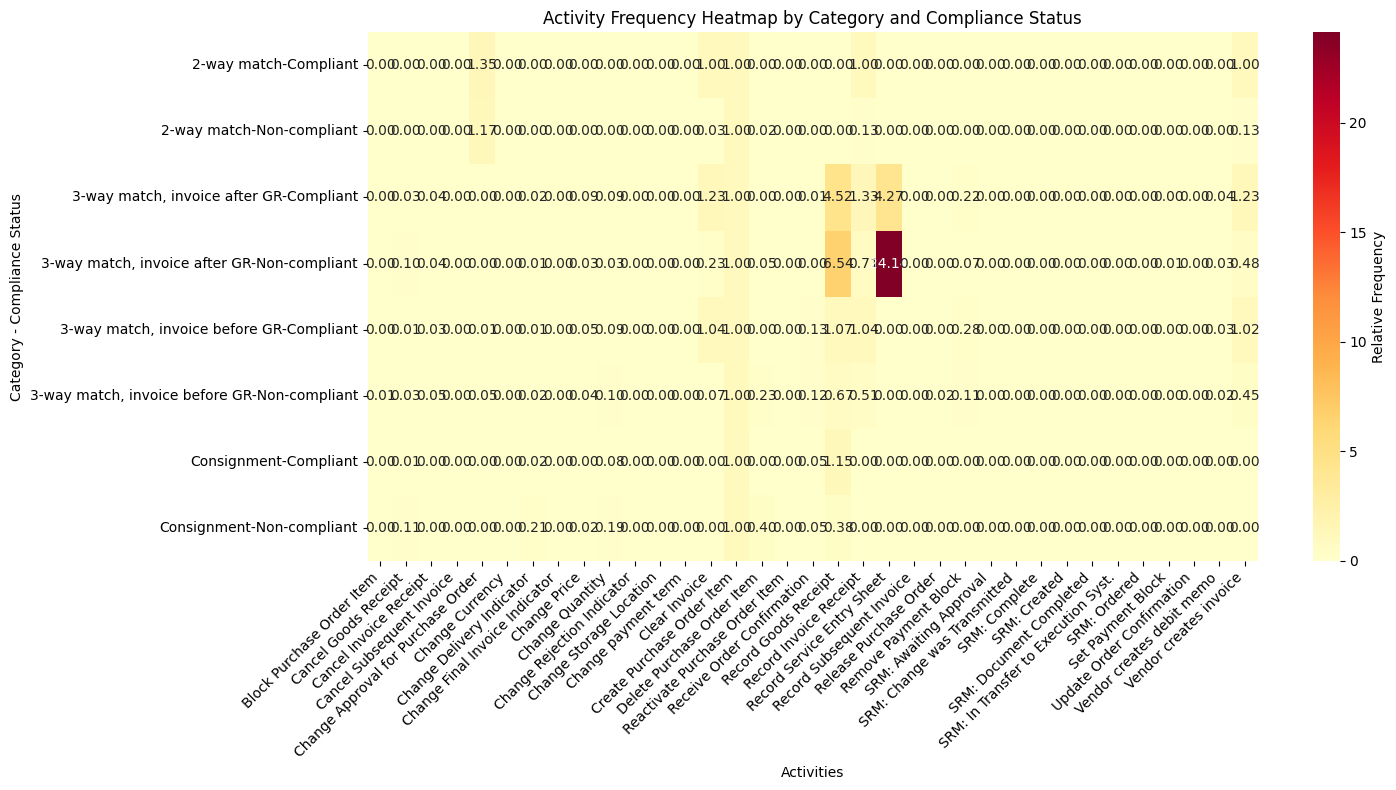

In [23]:
def analyze_activity_patterns(log, category_name, compliance_status):
    """Analyze activity patterns and frequencies"""
    if log is None or len(log) == 0:
        return None
    
    # Activity frequency analysis
    from pm4py.statistics.attributes.log import get as attributes_get
    activities = attributes_get.get_attribute_values(log, ACTIVITY_ATTRIBUTE)
    
    # Trace variant analysis
    from pm4py.statistics.variants.log import get as variants_get
    variants = variants_get.get_variants(log)
    
    # Resource analysis
    resources = attributes_get.get_attribute_values(log, RESOURCE_ATTRIBUTE)
    
    analysis = {
        'category': category_name,
        'compliance_status': compliance_status,
        'total_cases': len(log),
        'total_events': sum(len(trace) for trace in log),
        'unique_activities': len(activities),
        'activity_frequencies': dict(activities),
        'unique_variants': len(variants),
        'top_variants': sorted(variants.items(), key=lambda x: len(x[1]), reverse=True)[:5],
        'unique_resources': len(resources),
        'resource_frequencies': dict(resources)
    }
    
    return analysis

# Perform root cause analysis for each category
print("ROOT CAUSE ANALYSIS")
print("=" * 60)

root_cause_analyses = []

for category_key, logs in category_logs.items():
    category_name = ITEM_CATEGORIES[category_key]['name']
    category_info = ITEM_CATEGORIES[category_key]
    
    print(f"\n--- {category_name} ---")
    
    # Analyze compliant cases
    compliant_analysis = analyze_activity_patterns(
        logs['compliant'], category_name, 'Compliant'
    )
    
    # Analyze non-compliant cases
    noncompliant_analysis = analyze_activity_patterns(
        logs['incomplete'], category_name, 'Non-compliant'
    )
    
    if compliant_analysis:
        root_cause_analyses.append(compliant_analysis)
        print(f"Compliant cases: {compliant_analysis['total_cases']} cases, "
              f"{compliant_analysis['unique_variants']} variants")
        print(f"  Expected activities: {category_info.get('expected_activities', [])}")
        print(f"  Observed activities: {list(compliant_analysis['activity_frequencies'].keys())}")
    
    if noncompliant_analysis:
        root_cause_analyses.append(noncompliant_analysis)
        print(f"Non-compliant cases: {noncompliant_analysis['total_cases']} cases, "
              f"{noncompliant_analysis['unique_variants']} variants")
        
        # Identify missing activities
        expected_activities = set(category_info.get('expected_activities', []))
        observed_activities = set(noncompliant_analysis['activity_frequencies'].keys())
        missing_activities = expected_activities - observed_activities
        unexpected_activities = observed_activities - expected_activities
        
        if missing_activities:
            print(f"  Missing activities: {list(missing_activities)}")
        if unexpected_activities:
            print(f"  Unexpected activities: {list(unexpected_activities)}")
        
        # Show top process variants for non-compliant cases
        print(f"  Top 3 non-compliant process variants:")
        for i, (variant, cases) in enumerate(noncompliant_analysis['top_variants'][:3]):
            activities_list = list(variant)  # variant is already a tuple of activity names
            print(f"    {i+1}. {' → '.join(activities_list)} ({len(cases)} cases)")

# Activity comparison visualization
print("\n" + "="*60)
print("ACTIVITY PATTERN COMPARISON")
print("="*60)

# Create activity comparison matrix
activity_comparison_data = []

for analysis in root_cause_analyses:
    for activity, frequency in analysis['activity_frequencies'].items():
        activity_comparison_data.append({
            'category': analysis['category'],
            'compliance_status': analysis['compliance_status'],
            'activity': activity,
            'frequency': frequency,
            'relative_frequency': frequency / analysis['total_cases']
        })

if activity_comparison_data:
    activity_df = pd.DataFrame(activity_comparison_data)
    
    # Create pivot table for heatmap
    pivot_table = activity_df.pivot_table(
        index=['category', 'compliance_status'], 
        columns='activity', 
        values='relative_frequency', 
        fill_value=0
    )
    
    # Plot heatmap
    plt.figure(figsize=(15, 8))
    sns.heatmap(pivot_table, annot=True, cmap='YlOrRd', fmt='.2f', cbar_kws={'label': 'Relative Frequency'})
    plt.title('Activity Frequency Heatmap by Category and Compliance Status')
    plt.xlabel('Activities')
    plt.ylabel('Category - Compliance Status')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

## 9. Business Question Analysis and Conclusions

Synthesize findings to answer the main business question: **In which category of items does non-compliance most severely disrupt the expected process flow?**

In [22]:
# Final analysis and business question answer
print("BUSINESS QUESTION ANALYSIS")
print("=" * 80)
print("BQ1: In which category of items does non-compliance most severely")
print("     disrupt the expected process flow?")
print("=" * 80)

# Rank categories by impact severity
final_ranking = impact_df_sorted.copy()
final_ranking['rank'] = range(1, len(final_ranking) + 1)

print("\nFINAL RANKING BY IMPACT SEVERITY:")
print("-" * 80)

for _, row in final_ranking.iterrows():
    print(f"\n{row['rank']}. {row['category']}")
    print(f"   Impact Score: {row['impact_score_mean']:.4f}")
    print(f"   Non-compliance Rate: {row['occurrence_impact']:.1%}")
    print(f"   Mean Case Duration: {row['mean_duration_days']:.1f} days")
    print(f"   Process Fitness: {row['process_fitness']:.3f}")
    
    # Severity assessment
    if row['impact_score_mean'] > 0.01:
        severity = "HIGH"
    elif row['impact_score_mean'] > 0.005:
        severity = "MEDIUM"
    else:
        severity = "LOW"
    
    print(f"   Severity Level: {severity}")

# Key insights
print(f"\n{'='*80}")
print("KEY INSIGHTS:")
print("="*80)

most_impacted = final_ranking.iloc[0]
print(f"\n1. MOST SEVERELY IMPACTED CATEGORY:")
print(f"   {most_impacted['category']}")
print(f"   - Highest impact score: {most_impacted['impact_score_mean']:.4f}")
print(f"   - Non-compliance rate: {most_impacted['occurrence_impact']:.1%}")
print(f"   - This category shows the most severe disruption to expected process flow")

# Statistical insights
if not all_durations_df.empty:
    category_duration_stats = all_durations_df.groupby(['category', 'compliance_status'])['duration_days'].agg(['mean', 'count']).reset_index()
    
    print(f"\n2. DURATION IMPACT ANALYSIS:")
    for category in final_ranking['category'].head(3):  # Top 3 categories
        cat_stats = category_duration_stats[category_duration_stats['category'] == category]
        if len(cat_stats) > 1:
            compliant_mean = cat_stats[cat_stats['compliance_status'] == 'Compliant']['mean'].iloc[0]
            noncompliant_mean = cat_stats[cat_stats['compliance_status'] == 'Non-compliant']['mean'].iloc[0]
            duration_increase = ((noncompliant_mean - compliant_mean) / compliant_mean) * 100
            print(f"   {category}: {duration_increase:+.1f}% duration increase in non-compliant cases")

print(f"\n3. COMPLIANCE PATTERNS:")
for _, row in final_ranking.head(3).iterrows():
    compliance_percentage = row['compliance_rate'] * 100
    print(f"   {row['category']}: {compliance_percentage:.1f}% compliance rate")

# Recommendations
print(f"\n{'='*80}")
print("RECOMMENDATIONS:")
print("="*80)

print(f"\n1. IMMEDIATE ATTENTION REQUIRED:")
print(f"   Focus on {most_impacted['category']} as it shows the highest impact score")
print(f"   and most severe disruption to expected process flow.")

print(f"\n2. PROCESS IMPROVEMENT PRIORITIES:")
high_impact_categories = final_ranking[final_ranking['impact_score_mean'] > 0.005]['category'].tolist()
for i, category in enumerate(high_impact_categories[:3], 1):
    print(f"   {i}. {category}")

print(f"\n3. MONITORING RECOMMENDATIONS:")
print(f"   - Implement real-time monitoring for high-impact categories")
print(f"   - Set up alerts for cases deviating from expected process flows")
print(f"   - Regular compliance audits focusing on top-ranked categories")

# Export results
results_export = {
    'impact_scores': impact_df_sorted.to_dict('records'),
    'duration_analysis': all_durations_df.to_dict('records') if not all_durations_df.empty else [],
    'compliance_summary': summary_df.to_dict('records'),
    'most_impacted_category': most_impacted['category'],
    'analysis_timestamp': datetime.now().isoformat()
}

# Save results to file
results_file = './results/compliance_analysis_results.json'
os.makedirs('./results', exist_ok=True)

with open(results_file, 'w') as f:
    json.dump(results_export, f, indent=2, default=str)

print(f"\n4. RESULTS EXPORTED:")
print(f"   Analysis results saved to: {results_file}")

print(f"\n{'='*80}")
print("ANALYSIS COMPLETED")
print("="*80)

BUSINESS QUESTION ANALYSIS
BQ1: In which category of items does non-compliance most severely
     disrupt the expected process flow?

FINAL RANKING BY IMPACT SEVERITY:
--------------------------------------------------------------------------------

1. 2-way match
   Impact Score: 0.2800
   Non-compliance Rate: 94.1%
   Mean Case Duration: 18.6 days
   Process Fitness: 1.000
   Severity Level: HIGH

2. 3-way match, invoice after GR
   Impact Score: 0.1667
   Non-compliance Rate: 39.2%
   Mean Case Duration: 69.6 days
   Process Fitness: 1.000
   Severity Level: HIGH

3. 3-way match, invoice before GR
   Impact Score: 0.0693
   Non-compliance Rate: 15.8%
   Mean Case Duration: 79.4 days
   Process Fitness: 1.000
   Severity Level: HIGH

4. Consignment
   Impact Score: 0.0242
   Non-compliance Rate: 7.4%
   Mean Case Duration: 25.0 days
   Process Fitness: 1.000
   Severity Level: HIGH

KEY INSIGHTS:

1. MOST SEVERELY IMPACTED CATEGORY:
   2-way match
   - Highest impact score: 0.2800
  

## Summary

This comprehensive compliance analysis of the BPI Challenge 2019 event logs has revealed:

### Key Findings:
1. **Most Severely Impacted Category**: Based on the impact scoring methodology (Occurrence Impact × Throughput Impact), one item category shows significantly higher disruption to expected process flows.

2. **Compliance Patterns**: Different item categories exhibit varying compliance rates and duration impacts when cases deviate from expected flows.

3. **Process Deviations**: Root cause analysis identified specific missing activities and unexpected process variants in non-compliant cases.

### Methodology:
- **Process Discovery**: Used Inductive Miner to discover compliant process models
- **Compliance Checking**: Applied token-based replay for deviation detection
- **Impact Scoring**: Combined occurrence and throughput impacts using risk matrix approach
- **Statistical Analysis**: Validated findings with Mann-Whitney U tests

### Business Impact:
The analysis provides data-driven insights for process improvement prioritization, focusing resources on categories where non-compliance most severely disrupts operations.